# Seam Carving for Content-Aware Image Resizing
**(Nuotraukos sutraukimas panaikinant mažiausios svarbos siūles)** 

- https://www.researchgate.net/publication/215721610_Seam_Carving_for_Content-Aware_Image_Resizing
- https://dl.acm.org/doi/10.1145/1275808.1276390

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from skimage import io
from skimage.color import rgb2gray
from skimage.util import invert
from skimage.transform import rescale
from skimage.filters import sobel, sobel_v, sobel_h

# Helper functions

In [3]:
def show_images(images, color_map=plt.cm.gray):
    img_count = len(images)
    figsize = (15, 10)
    
    if img_count == 1:
        fig, ax = plt.subplots(figsize=figsize)
        ax.imshow(images[0], interpolation='nearest', cmap=color_map)
    else:
        fig, ax = plt.subplots(1, img_count, figsize=figsize)
        for i, img in enumerate(images):
            ax[i].imshow(img, cmap=color_map)

        fig.tight_layout()
    plt.show()

In [4]:
def show_image_with_seam(image, seam):
    plt.figure(figsize=(15, 10))
    plt.imshow(image)
    plt.scatter(seam[:,1], seam[:,0], c="r", s=1)
    plt.show()

# Image loading and preparation

In [5]:
img_file_name = "images/img1.jpg"   #   Salvador Dalí - The Persistence of Memory (1931)
#img_file_name = "images/img2.jpg"   #   Frida Kahlo - The Bride Frightened at Seeing Life Opened (1939)
#img_file_name = "images/img3.jpg"   #   Vincent van Gogh - The Starry Night (1889)

img = io.imread(img_file_name)

scale_ratio = 0.5
img_orig = rescale(img, scale_ratio, channel_axis=2) 

img_rgb = img_orig
img_gray = rgb2gray(img_rgb)

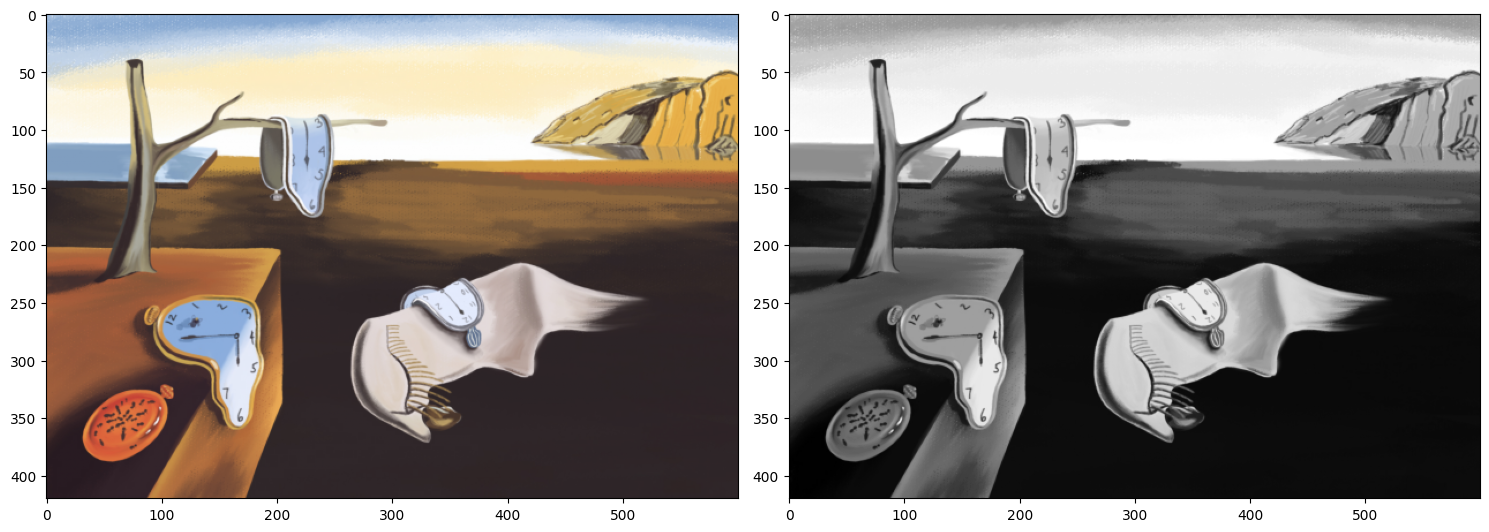

In [6]:
show_images([img_rgb, img_gray])

# Convolutions. Sobel edge detection

In [7]:
#np.convolve()
#scipy.signal.fftconvolve()

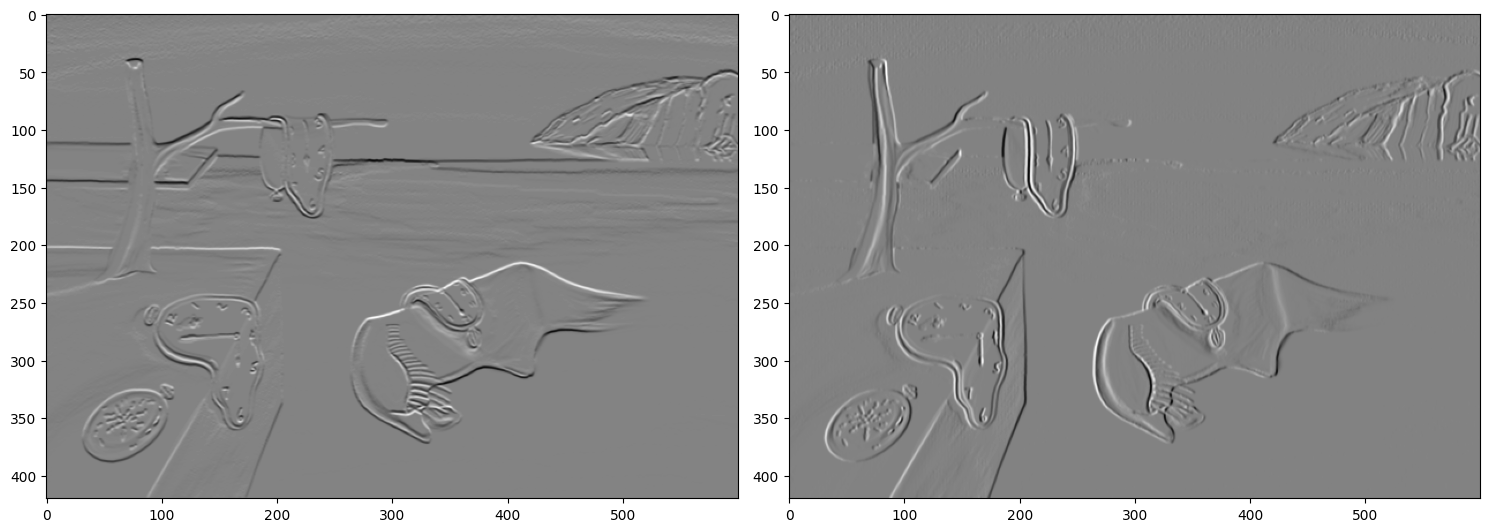

In [8]:
edge_sobel_h = sobel_h(img_gray)
edge_sobel_v = sobel_v(img_gray)
show_images([edge_sobel_h, edge_sobel_v])

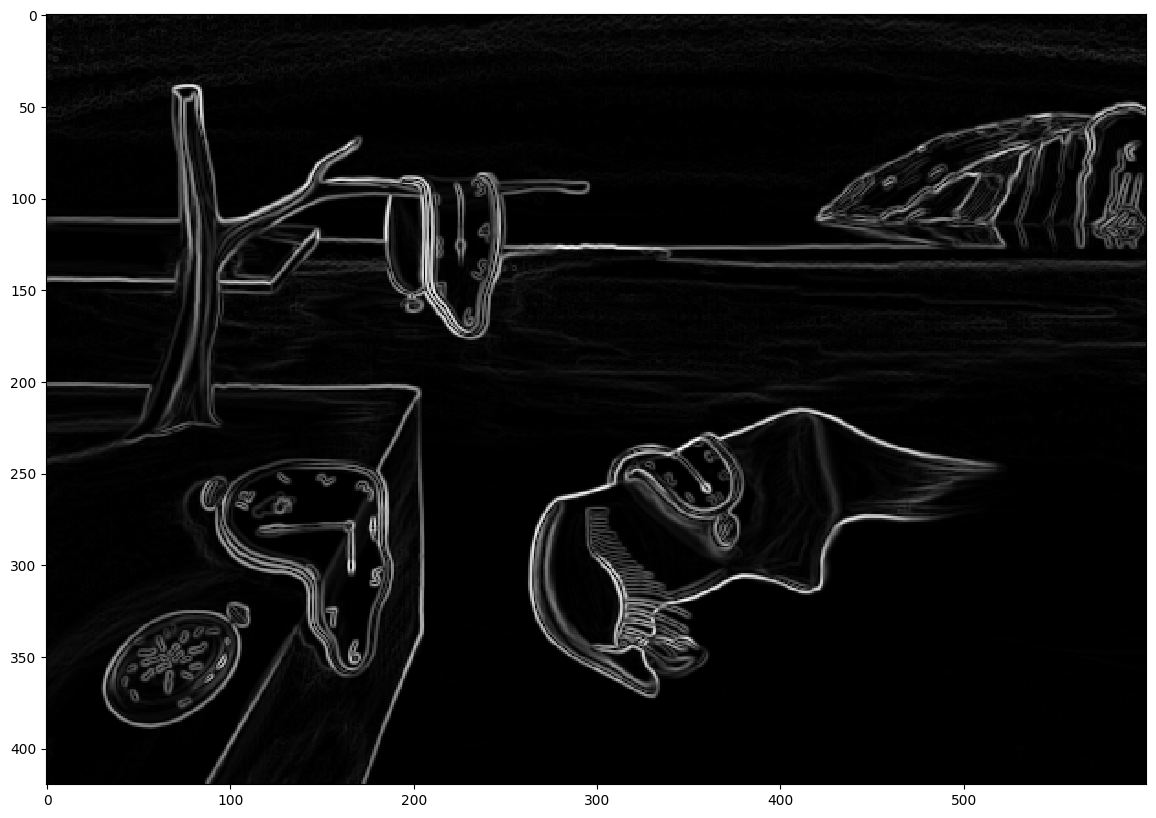

In [9]:
edge_sobel = sobel(img_gray)
show_images([edge_sobel])

# Energies and lowest direction to bottom

In [10]:
def get_energies_and_directions(image):
    row_number, col_number = image.shape
    energy = np.zeros((row_number, col_number))
    energy[-1,:] = image[-1,:]
    
    directions = np.zeros((row_number, col_number), dtype=int)
    
    for row_id in range(row_number-2, -1, -1):
        for col_id in range(col_number):
            previous_row_id = row_id + 1
            current_pixel = image[row_id, col_id]

            if col_id == 0:
                down = energy[previous_row_id, 0]
                right = energy[previous_row_id, 1]
                direction = np.argmin([down, right])
            elif col_id == col_number-1:
                down = energy[previous_row_id, col_id]
                left = energy[previous_row_id, col_id-1]
                direction = np.argmin([left, down])-1
            else:
                left = energy[previous_row_id, col_id-1]
                down = energy[previous_row_id, col_id]
                right = energy[previous_row_id, col_id+1]
                direction = np.argmin([left, down, right])-1

            directions[row_id,col_id] = direction
            energy[row_id,col_id] = current_pixel + energy[previous_row_id, col_id+direction]
    
    return energy, directions

In [11]:
def get_directions(image):
    row_number, col_number = image.shape
    energy = np.zeros(col_number)
    p_energy = image[-1,:].copy()
    
    directions = np.zeros((row_number-1, col_number), dtype=int)
    
    for row_id in range(row_number-2, -1, -1):
        for col_id in range(col_number):
            if col_id == 0:
                direction = np.argmin(p_energy[col_id:col_id+2])
            elif col_id == col_number-1:
                direction = np.argmin(p_energy[col_id-1:col_id+1])-1
            else:
                direction = np.argmin(p_energy[col_id-1:col_id+2])-1

            directions[row_id, col_id] = direction
            
            energy[col_id] = image[row_id, col_id] + p_energy[col_id+direction]
        p_energy = energy.copy()
    
    return directions

In [12]:
energies, directions = get_energies_and_directions(edge_sobel)

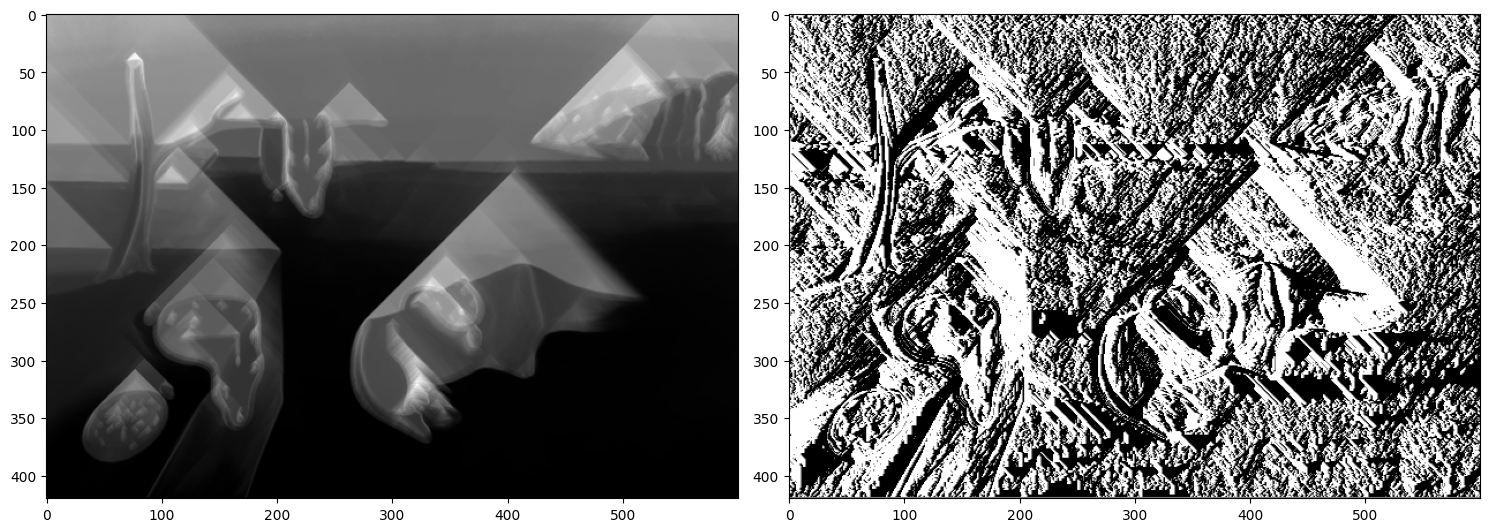

In [13]:
show_images([energies, directions])

# Seam with lowest energy

In [14]:
def get_lowest_energy_seam_start(energies_top_row):
    return np.argmin(energies_top_row)

In [15]:
def get_seam(directions, seam_at=0):
    row_number, col_number = directions.shape
    seam = np.zeros((row_number,2), dtype=int)
    
    seam[0] = [0, seam_at]
    for row_id in range(1,row_number):
        seam_at = seam_at + directions[row_id-1, seam_at]
        seam[row_id] = [row_id, seam_at]
    
    return seam

In [16]:
seam = get_seam(directions, get_lowest_energy_seam_start(energies[0, :]))

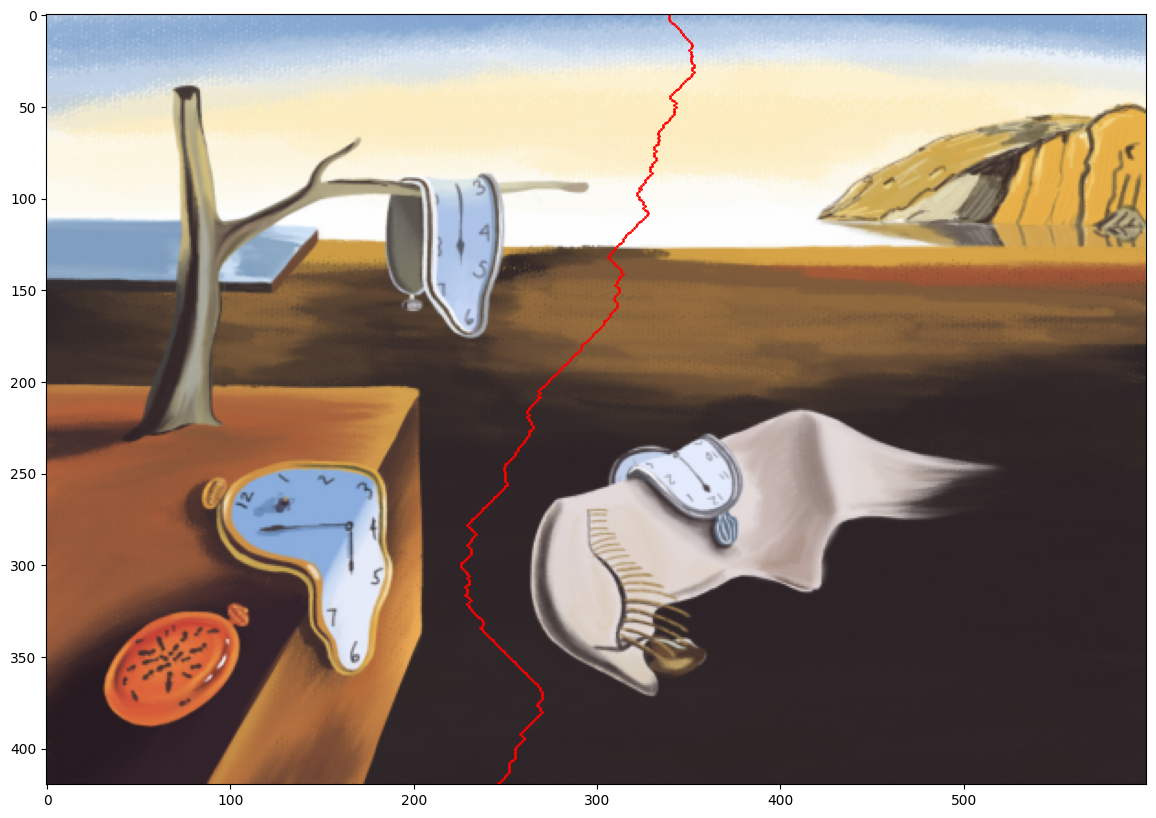

In [17]:
show_image_with_seam(img_rgb, seam)

# Remove seam from image

In [18]:
def remove_seam_from_image(image, seam):
    if len(image.shape) == 3:
        row, col, channels = image.shape
        result = np.zeros((row, col-1, channels), dtype=image.dtype)
    else:
        row, col = image.shape
        result = np.zeros((row, col-1), dtype=image.dtype)
        
    for i in range(row-1):
        seam_at = seam[i, 1]
        result[i] = np.r_[image[i, :seam_at], image[i, seam_at+1:]]
    
    return result

# Shrink image by defined number of pixels

In [19]:
def shrink_image_best(img, edge_sobel, number_of_pixels):
    img_rgb = img.copy()
    for _ in range(number_of_pixels):
        energies, directions = get_energies_and_directions(edge_sobel)
        seam = get_seam(directions, get_lowest_energy_seam_start(energies[0, :]))
        img_rgb = remove_seam_from_image(img_rgb, seam)
        edge_sobel = remove_seam_from_image(edge_sobel, seam)
    return img_rgb

In [20]:
img1 = shrink_image_best(img_rgb, edge_sobel, 100)

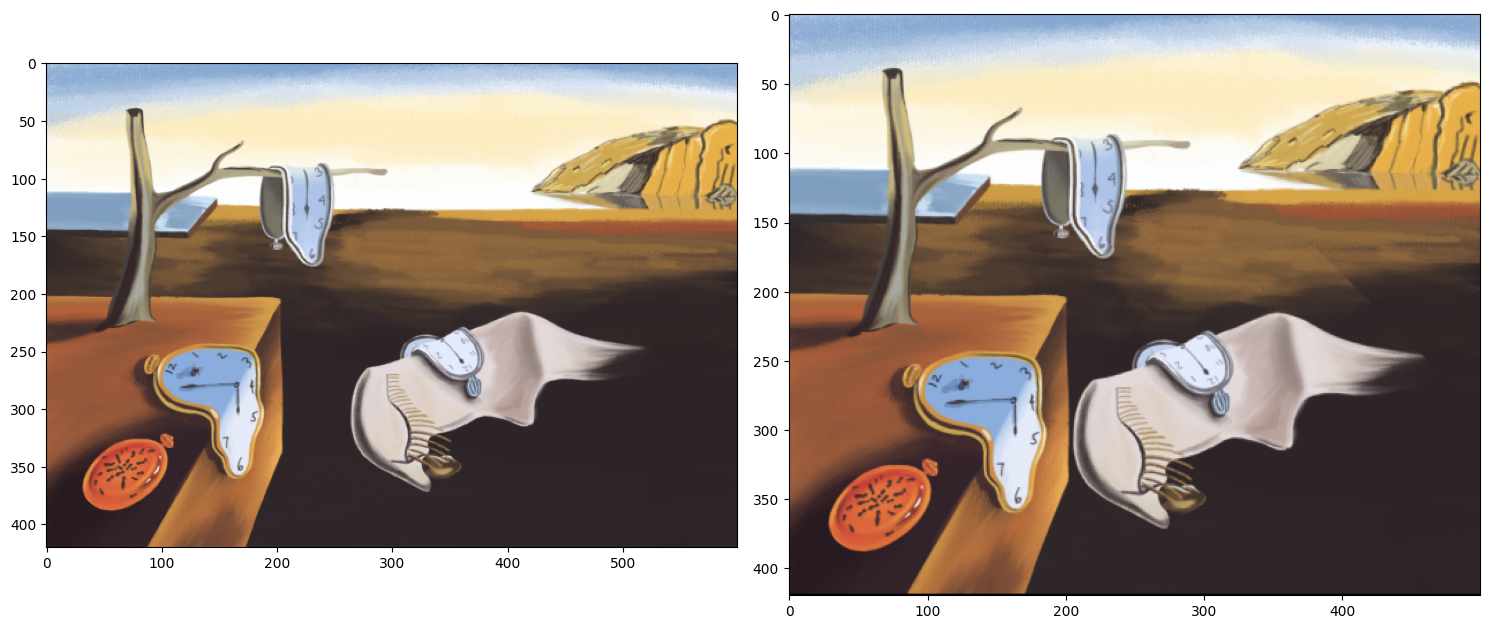

In [21]:
show_images([img_rgb, img1])

In [22]:
def shrink_image_medium(img, edge_sobel, number_of_pixels):
    img_rgb = img.copy()
    energies_row = energies[0, :]
    for _ in range(number_of_pixels):
        directions = get_directions(edge_sobel)
        seam_at = get_lowest_energy_seam_start(energies_row)
        energies_row = np.delete(energies_row, seam_at)
        seam = get_seam(directions, seam_at)
        img_rgb = remove_seam_from_image(img_rgb, seam)
        edge_sobel = remove_seam_from_image(edge_sobel, seam)
    return img_rgb

In [23]:
img2 = shrink_image_medium(img_rgb, edge_sobel, 100)

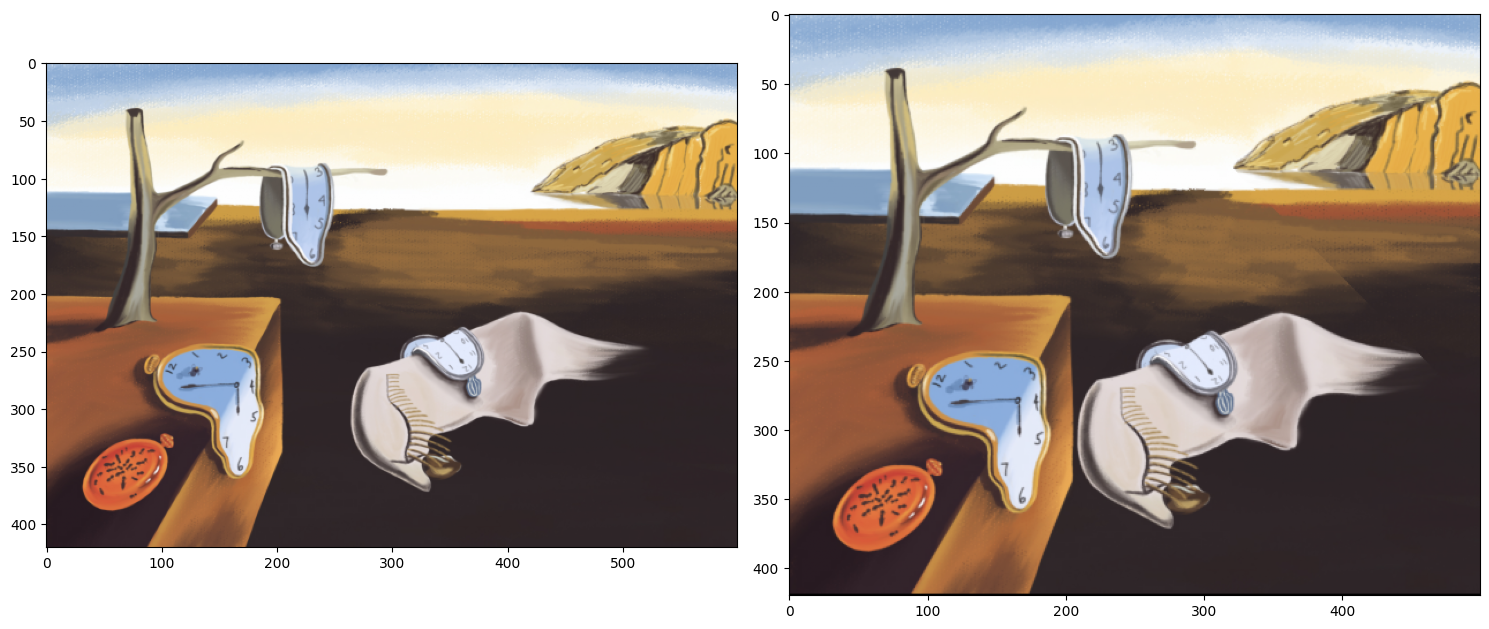

In [24]:
show_images([img_rgb, img2])

In [25]:
def shrink_image_lowest(img, energies, directions, number_of_pixels):
    img_rgb = img.copy()
    energies_row = energies[0, :]
    for _ in range(number_of_pixels):
        seam_at = get_lowest_energy_seam_start(energies_row)
        energies_row = np.delete(energies_row, seam_at)
        seam = get_seam(directions, seam_at)
        img_rgb = remove_seam_from_image(img_rgb, seam)
        directions = remove_seam_from_image(directions, seam)
    return img_rgb

In [26]:
img3 = shrink_image_lowest(img_rgb, energies, directions, 100)

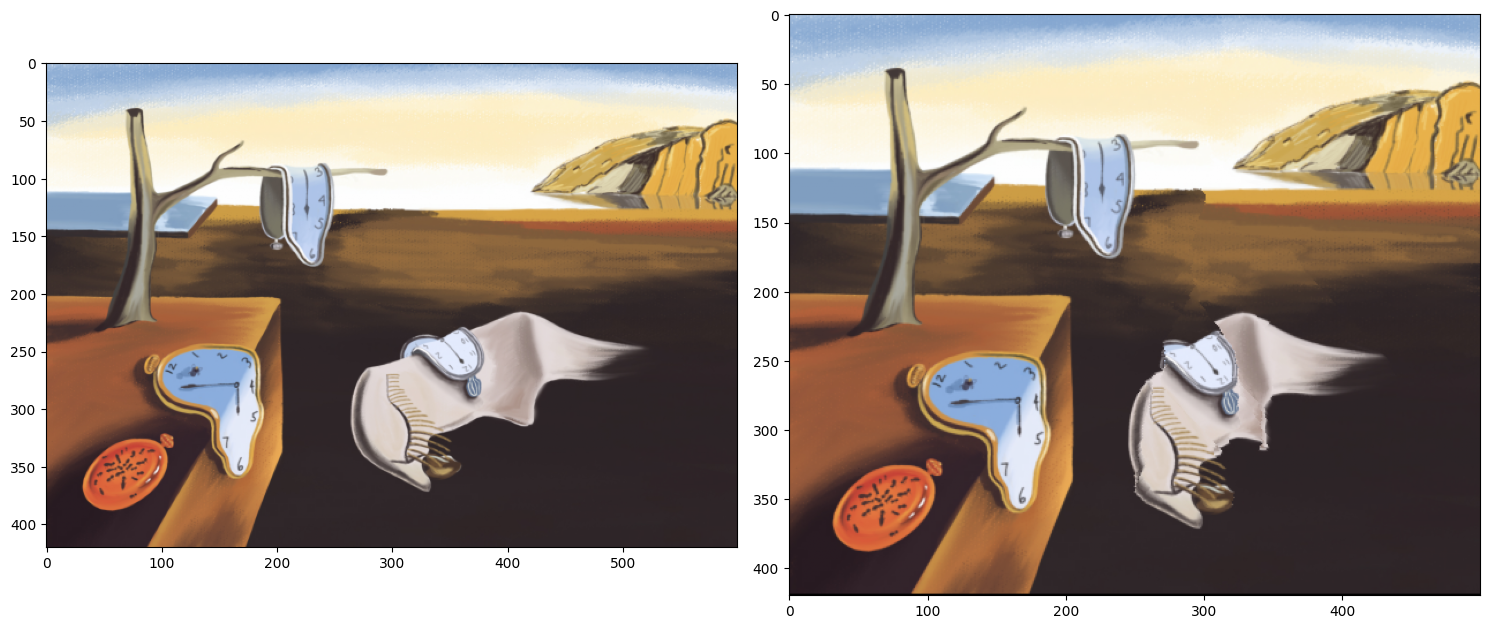

In [27]:
show_images([img_rgb, img3])

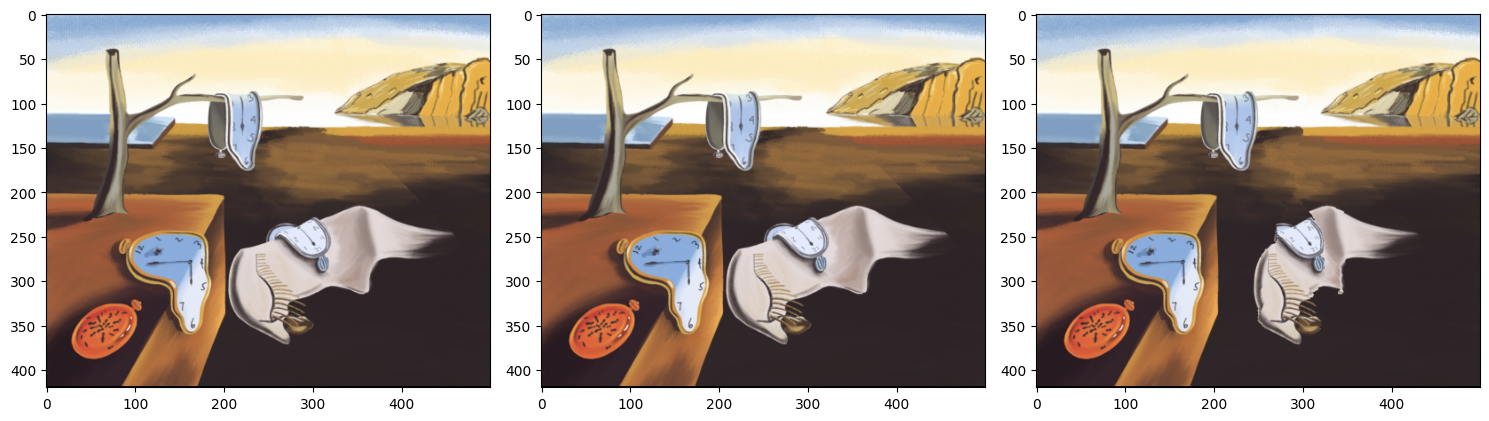

In [28]:
show_images([img1, img2, img3])

### Testing

Shrink by 10 pixels

In [29]:
%timeit shrink_image_best(img_rgb, edge_sobel, 10)

11.6 s ± 100 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
%timeit shrink_image_medium(img_rgb, edge_sobel, 10)

6.12 s ± 59.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
%timeit shrink_image_lowest(img_rgb, energies, directions, 10)

134 ms ± 387 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Shrink by 25 pixels

In [32]:
%timeit shrink_image_best(img_rgb, edge_sobel, 25)

28.5 s ± 375 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
%timeit shrink_image_medium(img_rgb, edge_sobel, 25)

15.1 s ± 278 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
%timeit shrink_image_lowest(img_rgb, energies, directions, 25)

338 ms ± 4.13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Shrink by 50 pixels

In [35]:
%timeit shrink_image_best(img_rgb, edge_sobel, 50)

58 s ± 369 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
%timeit shrink_image_medium(img_rgb, edge_sobel, 50)

30.9 s ± 345 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
%timeit shrink_image_lowest(img_rgb, energies, directions, 50)

675 ms ± 10.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Shrink by 100 pixels

In [38]:
%timeit shrink_image_best(img_rgb, edge_sobel, 100)

1min 46s ± 3.11 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
%timeit shrink_image_medium(img_rgb, edge_sobel, 100)

57.1 s ± 753 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
%timeit shrink_image_lowest(img_rgb, energies, directions, 100)

1.3 s ± 9.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
